In [1]:
#init
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VECM, VAR
from statsmodels.tsa.vector_ar.vecm import select_coint_rank, select_order, coint_johansen
import matplotlib.pyplot as plt
from io import BytesIO
import pandas_datareader.data as dat_aq
from datetime import datetime, timedelta
import statsmodels.tsa.api as tsa
from functools import partial

import seaborn as sns

import bekk

D:\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
def ready_data(data, ret_type):
    df = pd.DataFrame(index = data.index)
    #df.index = data.index
    df['Data'] = data
    if ret_type == 'pct_chg':
        df['pct_chg'] = np.log(df.iloc[:,0].pct_change()*100)
        df['pct_chg'].fillna(method = 'bfill', inplace = True)
        df.dropna(inplace = True)
        return (df.pct_chg[:])
    elif ret_type is None:
        return df[1:]

In [4]:
#import s&p data
sp500 = pd.read_csv('^GSPC.csv', header = 0, index_col = 'Date')
sp500.index = pd.to_datetime(sp500.index, format = '%d-%m-%y')
sp500 = sp500[1:]
#sp500 = sp500.resample('W').mean()
sp500.head()
print(len(sp500))

#import nifty50 data
nifty = pd.read_csv('^NSEI.csv', header = 0, index_col = 'Date')
nifty.index = pd.to_datetime(nifty.index, format = '%d-%m-%y')
nifty = nifty.reindex(index = sp500.index, method = 'bfill')
nifty.fillna(method = 'bfill', inplace=True)
#nifty = nifty.resample('W').mean()
nifty.head()
print(len(nifty))

sing_sti = pd.read_csv('^sti_d.csv', header = 0, index_col = 'Date')
sing_sti.index = pd.to_datetime(sing_sti.index, format = '%Y-%m-%d')
sing_sti = sing_sti.reindex(index = sp500.index, method = 'bfill')
sing_sti.fillna(method = 'bfill', inplace=True)
#nifty = nifty.resample('W').mean()
#nifty.head()
print(len(sing_sti))

uk_100 = pd.read_csv('^ukx_d.csv', header = 0, index_col = 'Date')
uk_100.index = pd.to_datetime(uk_100.index, format = '%Y-%m-%d')
uk_100 = uk_100.reindex(index = sp500.index, method = 'bfill')
uk_100.fillna(method = 'bfill', inplace=True)
#nifty = nifty.resample('W').mean()
#nifty.head()
print(len(uk_100))

hangseng = pd.read_csv('^hsi_d.csv', header = 0, index_col = 'Date')
hangseng.index = pd.to_datetime(hangseng.index, format = '%Y-%m-%d')
hangseng = hangseng.reindex(index = sp500.index, method = 'bfill')
hangseng.fillna(method = 'bfill', inplace=True)
#nifty = nifty.resample('W').mean()
#nifty.head()
print(len(hangseng))

nikkei = pd.read_csv('^nkx_d.csv', header = 0, index_col = 'Date')
nikkei.index = pd.to_datetime(nikkei.index, format = '%Y-%m-%d')
nikkei = nikkei.reindex(index = sp500.index, method = 'bfill')
nikkei.fillna(method = 'bfill', inplace=True)
#nifty = nifty.resample('W').mean()
#nifty.head()
print(len(nikkei))

shanghai_comp = pd.read_csv('^shc_d.csv', header = 0, index_col = 'Date')
shanghai_comp.index = pd.to_datetime(shanghai_comp.index, format = '%Y-%m-%d')
shanghai_comp = shanghai_comp.reindex(index = sp500.index, method = 'bfill')
shanghai_comp.fillna(method = 'bfill', inplace=True)
#nifty = nifty.resample('W').mean()
#nifty.head()
print(len(shanghai_comp))

3102
3102
3102
3102
3102
3102
3102


In [111]:
sp500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-03,1447.550049,1456.800049,1443.729980,1447.160034,1447.160034,3429500000
2008-01-04,1444.010010,1444.010010,1411.189941,1411.630005,1411.630005,4166000000
2008-01-07,1414.069946,1423.869995,1403.449951,1416.180054,1416.180054,4221260000
2008-01-08,1415.709961,1430.280029,1388.300049,1390.189941,1390.189941,4705390000
2008-01-09,1390.250000,1409.189941,1378.699951,1409.130005,1409.130005,5351030000
...,...,...,...,...,...,...
2020-04-23,2810.419922,2844.899902,2794.260010,2797.800049,2797.800049,5756520000
2020-04-24,2812.639893,2842.709961,2791.760010,2836.739990,2836.739990,5374480000
2020-04-27,2854.649902,2887.719971,2852.889893,2878.479980,2878.479980,5194260000


In [134]:
sing_sti.describe()

,Open,High,Low,Close,Volume
count,3102.000000,3102.000000,3102.000000,3102.000000,3.102000e+03
mean,3007.340854,3021.450380,2991.988936,3006.842160,2.810478e+08
std,377.425374,373.261575,380.491995,376.429612,1.219368e+08
min,1461.360000,1485.750000,1455.470000,1456.950000,5.044950e+07
25%,2855.172500,2871.700000,2840.097500,2854.210000,2.033622e+08
50%,3094.845000,3110.645000,3082.585000,3096.365000,2.524539e+08
75%,3245.760000,3256.465000,3231.540000,3243.852500,3.282237e+08
max,3624.200000,3641.650000,3607.250000,3615.280000,2.189716e+09


In [137]:
shanghai_comp['Close'].describe()

count    3102.000000
mean     2814.238953
std       572.815390
min      1706.700000
25%      2344.790000
50%      2852.130000
75%      3132.352500
max      5497.890000
Name: Close, dtype: float64

In [ ]:
writer = pd.ExcelWriter('nifty.xlsx')
df['nifty'].describe().to_excel(writer, sheet_name = 'Sheet2')
df['nifty'].iloc[0:1000].describe().to_excel(writer, sheet_name = 'Sheet3')
df['nifty'].iloc[1001:2001].describe().to_excel(writer, sheet_name = 'Sheet4')
df['nifty'].iloc[2002:3002].describe().to_excel(writer, sheet_name = 'Sheet5')
writer.save()

In [ ]:
writer = pd.ExcelWriter('nifty.xlsx')
df['sp500'].describe().to_excel(writer, sheet_name = 'Sheet2')
df['sp500'].iloc[0:1000].describe().to_excel(writer, sheet_name = 'Sheet3')
df['sp500'].iloc[1001:2001].describe().to_excel(writer, sheet_name = 'Sheet4')
df['sp500'].iloc[2002:3002].describe().to_excel(writer, sheet_name = 'Sheet5')
writer.save()

In [144]:
writer = pd.ExcelWriter('nifty.xlsx')
df['sing_sti'].describe().to_excel(writer, sheet_name = 'Sheet2')
df['sing_sti'].iloc[0:1000].describe().to_excel(writer, sheet_name = 'Sheet3')
df['sing_sti'].iloc[1001:2001].describe().to_excel(writer, sheet_name = 'Sheet4')
df['sing_sti'].iloc[2002:3002].describe().to_excel(writer, sheet_name = 'Sheet5')
writer.save()

In [145]:
writer = pd.ExcelWriter('nifty.xlsx')
df['hangseng'].describe().to_excel(writer, sheet_name = 'Sheet2')
df['hangseng'].iloc[0:1000].describe().to_excel(writer, sheet_name = 'Sheet3')
df['hangseng'].iloc[1001:2001].describe().to_excel(writer, sheet_name = 'Sheet4')
df['hangseng'].iloc[2002:3002].describe().to_excel(writer, sheet_name = 'Sheet5')
writer.save()

In [146]:
writer = pd.ExcelWriter('nifty.xlsx')
df['shanghai_comp'].describe().to_excel(writer, sheet_name = 'Sheet2')
df['shanghai_comp'].iloc[0:1000].describe().to_excel(writer, sheet_name = 'Sheet3')
df['shanghai_comp'].iloc[1001:2001].describe().to_excel(writer, sheet_name = 'Sheet4')
df['shanghai_comp'].iloc[2002:3002].describe().to_excel(writer, sheet_name = 'Sheet5')
writer.save()

In [147]:
writer = pd.ExcelWriter('nifty.xlsx')
df['uk_100'].describe().to_excel(writer, sheet_name = 'Sheet2')
df['uk_100'].iloc[0:1000].describe().to_excel(writer, sheet_name = 'Sheet3')
df['uk_100'].iloc[1001:2001].describe().to_excel(writer, sheet_name = 'Sheet4')
df['uk_100'].iloc[2002:3002].describe().to_excel(writer, sheet_name = 'Sheet5')
writer.save()

In [153]:
writer = pd.ExcelWriter('nifty.xlsx')
df['nikkei'].describe().to_excel(writer, sheet_name = 'Sheet2')
df['nikkei'].iloc[0:1000].describe().to_excel(writer, sheet_name = 'Sheet3')
df['nikkei'].iloc[1001:2001].describe().to_excel(writer, sheet_name = 'Sheet4')
df['nikkei'].iloc[2002:3002].describe().to_excel(writer, sheet_name = 'Sheet5')
writer.save()

In [252]:
sp500.describe()

,Open,High,Low,Close,Adj Close,Volume,pct_chg
count,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3.103000e+03,3103.000000
mean,1846.340953,1856.501921,1835.223236,1846.617836,1846.617836,4.017161e+09,0.031793
std,656.341772,657.472847,654.994202,656.350739,656.350739,1.154684e+09,1.336334
min,679.280029,695.270020,666.789978,676.530029,676.530029,1.025000e+09,-11.984055
25%,1287.849976,1296.339966,1277.500000,1288.005005,1288.005005,3.317005e+09,-0.396893
50%,1845.069946,1852.650024,1835.599976,1845.160034,1845.160034,3.732480e+09,0.063435
75%,2363.305054,2369.715088,2352.109986,2362.900024,2362.900024,4.411275e+09,0.564179
max,3380.449951,3393.520020,3378.830078,3386.149902,3386.149902,1.145623e+10,11.580037


In [21]:
nifty.describe()

,Open,High,Low,Close,Adj Close,Volume,pct_chg
count,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3.103000e+03,3103.000000
mean,7263.996006,7307.753580,7208.171445,7258.182504,7258.182504,1.377676e+05,0.024097
std,2488.616993,2486.987846,2483.378346,2484.497558,2484.497558,1.737451e+05,1.416727
min,2553.600098,2585.300049,2252.750000,2524.199951,2524.199951,0.000000e+00,-14.127216
25%,5265.649902,5300.550049,5225.699951,5261.425049,5261.425049,0.000000e+00,-0.552278
50%,6341.350098,6358.299805,6307.549805,6338.950195,6338.950195,1.328000e+05,0.000000
75%,8975.399903,9041.650391,8901.725097,8949.625000,8949.625000,1.994500e+05,0.620657
max,12349.400390,12389.049810,12321.400390,12362.299810,12362.299810,1.811000e+06,17.744066


In [4]:
sp500['pct_chg'] = ready_data(sp500['Close'], 'pct_chg')
sp500['pct_chg'].fillna(method = 'bfill', inplace = True)
sp500.describe()

,Open,High,Low,Close,Adj Close,Volume,pct_chg
count,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3.103000e+03,3103.000000
mean,1846.340953,1856.501921,1835.223236,1846.617836,1846.617836,4.017161e+09,0.031793
std,656.341772,657.472847,654.994202,656.350739,656.350739,1.154684e+09,1.336334
min,679.280029,695.270020,666.789978,676.530029,676.530029,1.025000e+09,-11.984055
25%,1287.849976,1296.339966,1277.500000,1288.005005,1288.005005,3.317005e+09,-0.396893
50%,1845.069946,1852.650024,1835.599976,1845.160034,1845.160034,3.732480e+09,0.063435
75%,2363.305054,2369.715088,2352.109986,2362.900024,2362.900024,4.411275e+09,0.564179
max,3380.449951,3393.520020,3378.830078,3386.149902,3386.149902,1.145623e+10,11.580037


In [5]:
nifty['pct_chg'] = ready_data(nifty['Close'], 'pct_chg')
nifty['pct_chg'].fillna(method = 'bfill', inplace = True)
nifty.describe()

,Open,High,Low,Close,Adj Close,Volume,pct_chg
count,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3.103000e+03,3103.000000
mean,7263.996006,7307.753580,7208.171445,7258.182504,7258.182504,1.377676e+05,0.024097
std,2488.616993,2486.987846,2483.378346,2484.497558,2484.497558,1.737451e+05,1.416727
min,2553.600098,2585.300049,2252.750000,2524.199951,2524.199951,0.000000e+00,-14.127216
25%,5265.649902,5300.550049,5225.699951,5261.425049,5261.425049,0.000000e+00,-0.552278
50%,6341.350098,6358.299805,6307.549805,6338.950195,6338.950195,1.328000e+05,0.000000
75%,8975.399903,9041.650391,8901.725097,8949.625000,8949.625000,1.994500e+05,0.620657
max,12349.400390,12389.049810,12321.400390,12362.299810,12362.299810,1.811000e+06,17.744066


In [ ]:
df = pd.DataFrame(index = sp500.iloc[0:].index)
df['nifty']

In [23]:
sm.stats.stattools.durbin_watson(sp500['pct_chg'])

2.297192975010083

In [127]:
res = sm.tsa.stattools.coint(sp500['Close'], nifty['Close'], maxlag=5, autolag = 't-stat', return_results = True)

In [128]:
res

(-3.157084904515578,
 0.07740261500870742,
 array([-3.89997408, -3.33810044, -3.04581753]))

In [175]:
res_adf_diff = sm.tsa.stattools.adfuller(sp500['pct_chg'].iloc[0:1000])

In [103]:
res_adf = sm.tsa.stattools.adfuller(sing_sti['Close'].iloc[:])

In [177]:
res_adf_diff

(-25.96797485485293,
 0.0,
 1,
 998,
 {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573},
 3921.7358132652907)

In [104]:
res_adf

(-2.3872400641145184,
 0.14537024062498627,
 19,
 3083,
 {'1%': -3.4324728521095658,
  '5%': -2.8624779427668594,
  '10%': -2.5672692900180105},
 29219.65841141348)

In [5]:
df = pd.DataFrame(index = sp500.iloc[:3000].index)
df['nifty'] = nifty['Close']
df['sp500'] = sp500['Close']
df['sing_sti'] = sing_sti['Close']
df['hangseng'] = hangseng['Close']
df['shanghai_comp'] = shanghai_comp['Close']
df['uk_100'] = uk_100['Close']
df['nikkei'] = nikkei['Close']

df = df.iloc[:3000]

res_order = select_order(df[['nifty','sp500']], maxlags = 5)
res_order.vecm = True
res_order.summary()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored

,AIC,BIC,FPE,HQIC
0,14.41,14.42,1.816e+06,14.42
1,14.36,14.38,1.718e+06,14.36
2,14.35,14.38*,1.703e+06,14.36*
3,14.35*,14.38,1.703e+06*,14.36
4,14.35,14.39,1.706e+06,14.37
5,14.35,14.40,1.706e+06,14.37


In [40]:
res_coint_rank = select_coint_rank(df[['nifty','sp500']], det_order = 1, k_ar_diff = 14, method = 'maxeig')
res_coint_rank.summary()

r_0,r_1,test statistic,critical value
0,1,15.86,17.15


In [41]:
res_vecm = VECM(df[['nifty','sp500']], coint_rank = 1, k_ar_diff = 14, deterministic = 'cili')
res_vecm_fit = res_vecm.fit()
res_vecm_fit.summary()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,coef,std err,z,P>|z|,[0.025,0.975]
L1.nifty,-0.0234,0.019,-1.230,0.219,-0.061,0.014
L1.sp500,0.9494,0.076,12.423,0.000,0.800,1.099
L2.nifty,-0.0026,0.019,-0.140,0.889,-0.039,0.034
L2.sp500,0.2945,0.079,3.732,0.000,0.140,0.449
L3.nifty,-0.0427,0.019,-2.292,0.022,-0.079,-0.006
L3.sp500,0.1162,0.079,1.468,0.142,-0.039,0.271
L4.nifty,-0.0210,0.019,-1.130,0.258,-0.058,0.015
L4.sp500,-0.0699,0.079,-0.883,0.377,-0.225,0.085
L5.nifty,-0.0169,0.019,-0.907,0.364,-0.053,0.020
L5.sp500,-0.0964,0.079,-1.217,0.224,-0.252,0.059


In [44]:
res_vecm_fit.resid

array([[-181.59347031,   14.5736674 ],
       [ 266.4216201 ,  -22.25044199],
       [ -87.69940382,   25.27140932],
       ...,
       [ -58.80478362,    7.06359845],
       [  44.88476376,   14.73591845],
       [ -46.0981913 ,  -11.02272091]])

In [213]:
res_johansen = coint_johansen(df[['nifty', 'sp500','hangseng','sing_sti','shanghai_comp','uk_100','nikkei']], det_order = 1, k_ar_diff = 57)
res_johansen.trace_stat

array([195.97072409, 130.83870659,  74.87175486,  47.38475454,
        23.40385276,   9.69682259,   3.04849616])

In [214]:
res_johansen.trace_stat_crit_vals

array([[133.7852, 139.278 , 150.0778],
       [102.4674, 107.3429, 116.9829],
       [ 75.1027,  79.3422,  87.7748],
       [ 51.6492,  55.2459,  62.5202],
       [ 32.0645,  35.0116,  41.0815],
       [ 16.1619,  18.3985,  23.1485],
       [  2.7055,   3.8415,   6.6349]])

In [307]:
res_vecm_fit.test_granger_causality('nifty', 'nikkei').summary()

Test statistic,Critical value,p-value,df
2.037,1.327,0.000,"(58, 3682)"


In [139]:
res_vecm_fit.lin_trend

array([], shape=(3, 0), dtype=float64)

In [37]:
res_vecm_fit.test_granger_causality('nifty','sp500').summary()

Test statistic,Critical value,p-value,df
103.5,2.997,0.000,"(2, 6188)"


In [69]:
res_vecm.test_granger_causality('sp500','nifty').signif

0.05

In [39]:
sm.stats.stattools.jarque_bera(sing_sti['Close'].iloc[2000:3000])

(32.15152707257624,
 1.0432408968287028e-07,
 -0.3317670466336413,
 2.4243619567698858)

In [37]:
sm.stats.stattools.jarque_bera(nifty['Close'].iloc[2000:3000])

(69.4100609218246,
 8.468310558754018e-16,
 -0.3512435155253594,
 1.9172472889300451)

In [38]:
sm.stats.stattools.jarque_bera(sp500['Close'].iloc[2000:3000])

(61.13924086350345,
 5.2939828811375316e-14,
 -0.22901723063325205,
 1.8785963202234504)

In [40]:
sm.stats.stattools.jarque_bera(hangseng['Close'].iloc[2000:3000])

(42.54783974774485,
 5.765725872724096e-10,
 -0.27798926018197134,
 2.156177720820434)

In [43]:
sm.stats.stattools.jarque_bera(shanghai_comp['Close'].iloc[2000:3000])

(12.738941189136904,
 0.0017130658919350867,
 -0.14779043075019202,
 2.5327029393908234)

In [42]:
sm.stats.stattools.jarque_bera(uk_100['Close'].iloc[2000:3000])

(213.86610736210878,
 3.627144463983783e-47,
 -1.1110790388597487,
 3.441361591347275)

In [41]:
sm.stats.stattools.jarque_bera(nikkei['Close'].iloc[2000:3000])

(70.55096028199931,
 4.786891989718693e-16,
 -0.45462445108029,
 2.069145832749424)

In [121]:
np.corrcoef(sp500['pct_chg'].iloc[2002:3002], nifty['pct_chg'].iloc[2002:3002])

array([[1.        , 0.22824561],
       [0.22824561, 1.        ]])

In [59]:
sm.stats.stattools.durbin_watson(sing_sti['Close'].iloc[:])

9.204503249610049e-05

In [60]:
sm.stats.stattools.durbin_watson(hangseng['Close'].iloc[:])

0.00018165511257783504

In [63]:
sm.stats.stattools.durbin_watson(shanghai_comp['Close'].iloc[:])

0.0002903971288316584

In [61]:
sm.stats.stattools.durbin_watson(uk_100['Close'].iloc[:])

0.00011543336368675091

In [62]:
sm.stats.stattools.durbin_watson(nikkei['Close'].iloc[:])

0.0001841134319722001

In [205]:
tsa.stattools.coint(df['nifty'].iloc[0:1000], df['sp500'].iloc[0:1000])

(-10.241189051163243,
 6.148904301732664e-17,
 array([-3.90743646, -3.34225305, -3.04869817]))

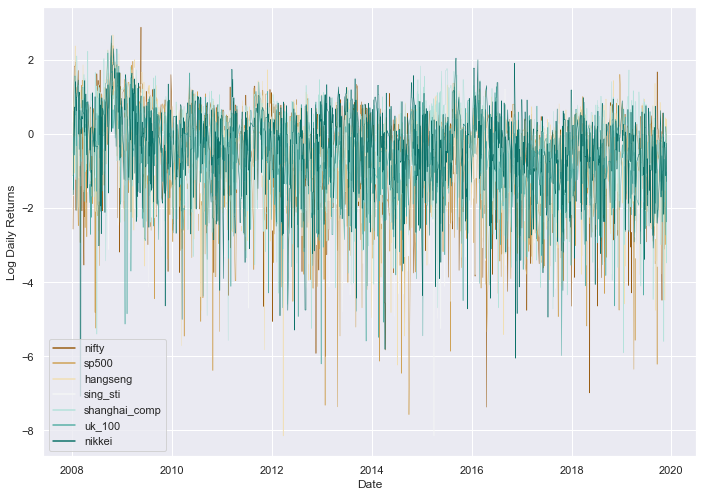

In [152]:
sns.set(style = 'whitegrid')

sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.lineplot(data=df_1, palette="BrBG", linewidth=.5, dashes = False)
plot.set(xlabel = 'Date', ylabel = 'Log Daily Returns')
plot = plot.get_figure()
plot.savefig('output.png')

In [6]:
df_1 = pd.DataFrame()
df_1['nifty'] = ready_data(df['nifty'], 'pct_chg')
df_1['sp500'] = ready_data(df['sp500'], 'pct_chg')
df_1['hangseng'] = ready_data(df['hangseng'], 'pct_chg')
df_1['sing_sti'] = ready_data(df['sing_sti'], 'pct_chg')
df_1['shanghai_comp'] = ready_data(df['shanghai_comp'], 'pct_chg')
df_1['uk_100'] = ready_data(df['uk_100'], 'pct_chg')
df_1['nikkei'] = ready_data(df['nikkei'], 'pct_chg')

df_1 = df_1.replace([np.inf, -np.inf], np.nan).dropna()

D:\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [54]:
df_1

,nifty,sp500,hangseng,sing_sti,shanghai_comp,uk_100,nikkei
Date,,,,,,,
2008-01-07,-2.570370,-1.132192,0.617797,-1.673858,-0.523318,-1.113832,-1.640290
2008-01-08,-1.970758,0.309254,0.617797,-1.673858,-0.088763,-1.113832,-1.640290
2008-01-09,-0.355486,0.309254,0.617797,-1.673858,-0.088763,-1.510061,-0.723096
2008-01-16,1.825680,0.762775,0.999335,0.978623,-0.578747,1.558365,0.725424
2008-01-17,1.825680,0.762775,0.999335,0.978623,-0.578747,1.558365,0.725424
...,...,...,...,...,...,...,...
2011-12-06,-0.764944,-2.202062,0.454288,0.191948,-1.226837,-4.294051,0.539046
2011-12-08,-0.280280,0.523743,0.360642,-1.330927,0.700502,-0.187985,0.318315
2011-12-09,-0.280280,0.523743,0.360642,-1.330927,0.700502,-0.187985,0.318315


In [7]:
res_var = VAR(df_1[['nifty','sp500']])
#res_var.endog_names
res_var_fit = res_var.fit(maxlags = 15, ic = 'aic', trend = 'ct')
use_target = False
restriction = 'diagonal'
nstocks = 2
nobs = len(df_1)
    # A, B, C - n x n matrices
amat = np.eye(nstocks) * .09**.5
bmat = np.eye(nstocks) * .9**.5
target = np.eye(nstocks)
param_true = bekk.ParamStandard.from_target(amat=amat, bmat=bmat, target=target)
print(param_true)
bekk_res = bekk.bekk_estimation.BEKK(res_var_fit.resid.to_numpy())
bekk_estimate = bekk_res.estimate(use_target = use_target, restriction = restriction)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




Max eigenvalue = 0.9900
Penalty = 0.0000

A =
[[0.3 0. ]
 [0.  0.3]]
B =
[[0.9486833 0.       ]
 [0.        0.9486833]]
C =
[[0.1 0. ]
 [0.  0.1]]

Unconditional variance =
[[1. 0.]
 [0. 1.]]



In [8]:
bekk_estimate

Model: standard
Restriction: diagonal
Use target: False
Matrix C is free: False
Number of parameters: 7
Iterations = 16
Optimization method = SLSQP
Optimization time = 3.6 s

Final parameters:

Max eigenvalue = 0.3606
Penalty = 23031.5318

A =
[[0.3618199  0.        ]
 [0.         0.38263515]]
B =
[[0.47927305 0.        ]
 [0.         0.17536465]]
C =
[[0.82269868 0.        ]
 [0.08783777 1.05114429]]

Unconditional variance =
[[1.05857111 0.09294318]
 [0.09294318 1.35217424]]

Variance target:
[[1.07717305 0.10414089]
 [0.10414089 1.34912958]]

Final log-likelihood (with penalty) = -4721.69
Final log-likelihood = 18309.84

In [16]:
bekk_res.likelihood

<bound method BEKK.likelihood of <bekk.bekk_estimation.BEKK object at 0x0000020DE63F1F88>>